# Contents

In this notebook, I'm showing my process of scraping NBA teams and players data from https://www.basketball-reference.com/. I created functions as listed below:


1. `get_mvp(season)`
> This function generates the name of the player who won the MVP in the determined season.


2. `get_allstar(season)`
> This function generates a list of players who were selected to the NBA all-star game in the determined season.

3. `team_records(season)`
> This function generates NBA team wins and losses in the determined season

4. `single(season,stats)`
> This function generates players' statistics on the court in a single determined season. The argument *stats* are:
  * per_game
  * per_minute
  * per_poss
  * totals
  * advanced
  * shooting
  * adj_shooting
  * play-by-play

5. `multiple(start_year,end_year,stats)`
> This function generates players' statistics on the court in multiple seasons. This function basically iterates function `single(season,stats)` from *start_year* to *end_year*

In the end, I created a class to gather all the functions listed above.

The main tools I used for the process are:
1. pandas (to process dataframe)
2. BeautifulSoup (to scrap the website's URL)
3. Regex (to select certain html pattern)
  











# 0. Library

In [1]:
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import ssl
import json
import re
import string
from urllib.request import urlopen
import pandas as pd
from datetime import datetime
!pip install pandasql
from pandasql import sqldf
!pip install inquirer
import time
import sys
pd.options.mode.chained_assignment = None 

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26781 sha256=1175a12407d6748c4966f052a9af783244e49d8e5664d6d5dde68f72231b5239
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql
     |████████████████████████████████| 76 kB 2.9 MB/s 


# 1. Get NBA MVP name

The first thing to do is to define the url to scrap which is https://www.basketball-reference.com/awards/mvp.html. 

In [ ]:
url = 'https://www.basketball-reference.com/awards/mvp.html'

The next thing to do is to use BeautifulSoup to scrap the table containing NBA player lists of MVP in each season.

In [ ]:
table_html = (BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id = 'mvp_NBA')[0])

*pandas* already built with function that can read table with html format. So to convert html to data frame, `pd.read_html` will be used.

In [ ]:
df = pd.read_html(table_html)[0]
df

Unnamed: 0_level_0 Unnamed: 1_level_0  ... Advanced       
               Season                 Lg  ...       WS  WS/48
0             2020-21                NBA  ...     15.6  0.301
1             2019-20                NBA  ...     11.1  0.279
2             2018-19                NBA  ...     14.4  0.292
3             2017-18                NBA  ...     15.4  0.289
4             2016-17                NBA  ...     13.1  0.224
..                ...                ...  ...      ...    ...
61            1959-60                NBA  ...     17.0  0.245
62            1958-59                NBA  ...     14.8  0.246
63            1957-58                NBA  ...     11.3  0.206
64            1956-57                NBA  ...      8.8  0.178
65            1955-56                NBA  ...     13.8  0.236

[66 rows x 18 columns]

We see that the data frame is still in a mess. So cleansing process is necessary. I will drop the header and all the columns except *Season* and *Player* column. I will also convert *Season* value to YYYY format

In [ ]:
  df.columns = df.columns.droplevel(0)
  df = df[['Season','Player']]
  df['Season'][0]
  for i in range(len(df)):
    df['Season'][i] = df['Season'][i][0:2] + df['Season'][i][5:7]
df

,Season,Player
0,2021,Nikola Jokić
1,2020,Giannis Antetokounmpo
2,2019,Giannis Antetokounmpo
3,2018,James Harden
4,2017,Russell Westbrook
...,...,...
61,1960,Wilt Chamberlain
62,1959,Bob Pettit
63,1958,Bill Russell
64,1957,Bob Cousy


So far so good, but I want to create a function that generates a single name from the determined season, therefore I will convert the dataframe to list.

In [ ]:
 mvp_lists = df.values.tolist()

Now I will create a function to print the MVP name if a certain season is selected

In [42]:
def get_mvp(season):
  season = str(season)
  url = 'https://www.basketball-reference.com/awards/mvp.html'
  table_html = str(BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id = 'mvp_NBA')[0])

  df = pd.read_html(table_html)[0]
  df.columns = df.columns.droplevel(0)
  df = df[['Season','Player']]
  df['Season'][0]

  for i in range(len(df)):
    df['Season'][i] = df['Season'][i][0:2] + df['Season'][i][5:7]

  mvp_lists = df.values.tolist()

  for data in mvp_lists:
    if season in data[0]:
      return data[1]
get_mvp(2008)

'Kobe Bryant'

# 2. Get NBA All-Star list

Because the data are separated in different links, I don't directly convert the html to dataframe. I will scrap the names and put them to list.

Note that there's no all star in 1999 season.

In [ ]:
season = 2020
url = f'https://www.basketball-reference.com/allstar/NBA_{season}.html'
print(url)

https://www.basketball-reference.com/allstar/NBA_2020.html


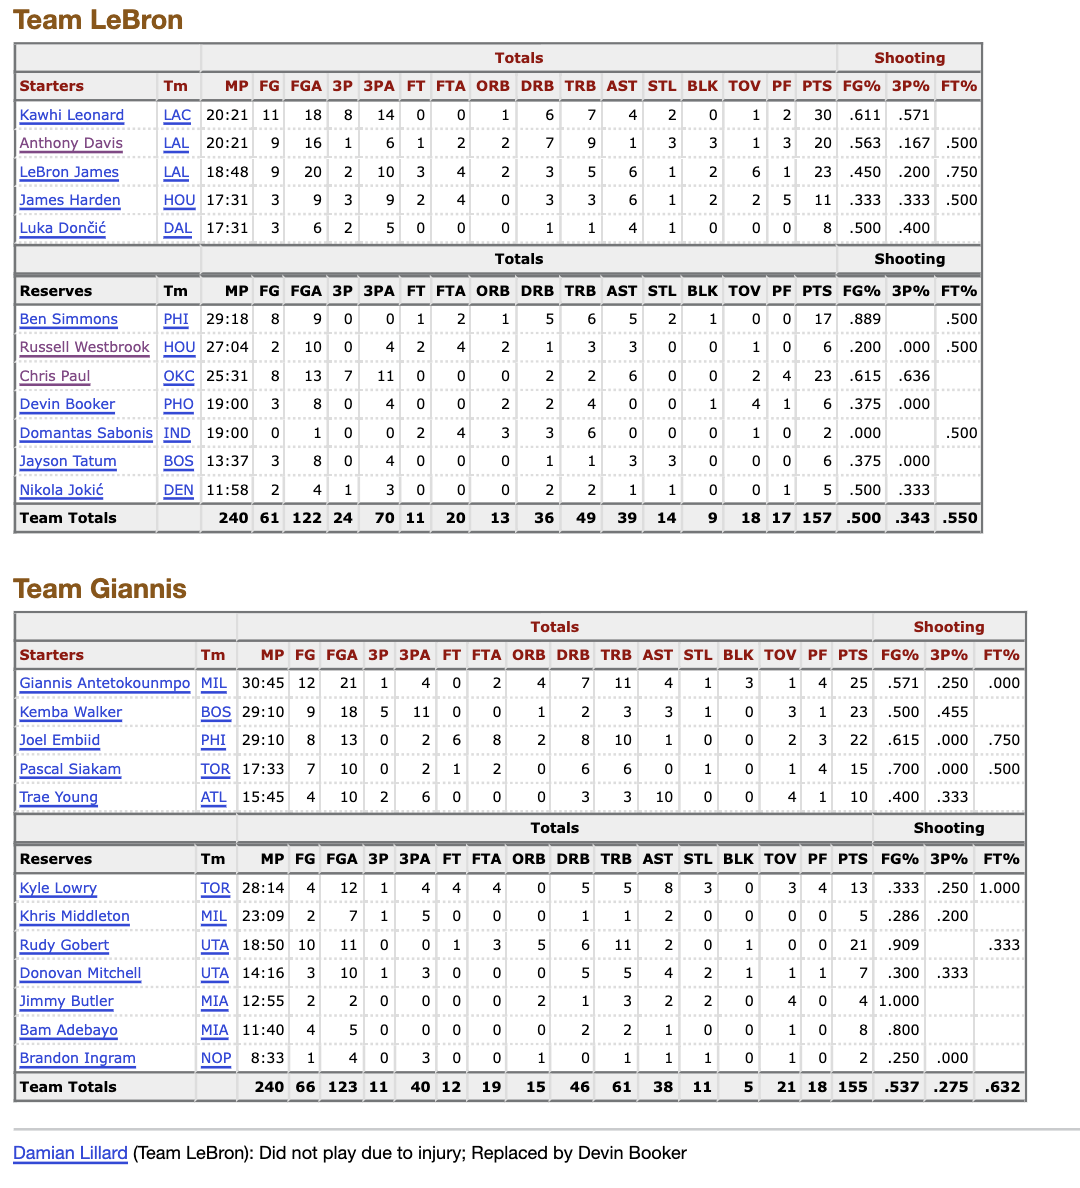

We can see that the players selected for the all-star game are stored in a hyperlink. To get that names, I will use BeautifulSoup and regex to get the names in a list of string

In [ ]:
name_html = BeautifulSoup(urlopen(url),'html.parser').findAll('a', string = re.compile('[a-z]'), href = re.compile('^/players/.+'), title= False) 
name_html

[<a href="/players/l/leonaka01.html">Kawhi Leonard</a>,
 <a href="/players/j/jamesle01.html">LeBron James</a>,
 <a href="/players/l/leonaka01.html">Kawhi Leonard</a>,
 <a href="/players/d/davisan02.html">Anthony Davis</a>,
 <a href="/players/j/jamesle01.html">LeBron James</a>,
 <a href="/players/h/hardeja01.html">James Harden</a>,
 <a href="/players/d/doncilu01.html">Luka Dončić</a>,
 <a href="/players/s/simmobe01.html">Ben Simmons</a>,
 <a href="/players/w/westbru01.html">Russell Westbrook</a>,
 <a href="/players/p/paulch01.html">Chris Paul</a>,
 <a href="/players/b/bookede01.html">Devin Booker</a>,
 <a href="/players/s/sabondo01.html">Domantas Sabonis</a>,
 <a href="/players/t/tatumja01.html">Jayson Tatum</a>,
 <a href="/players/j/jokicni01.html">Nikola Jokić</a>,
 <a href="/players/a/antetgi01.html">Giannis Antetokounmpo</a>,
 <a href="/players/w/walkeke02.html">Kemba Walker</a>,
 <a href="/players/e/embiijo01.html">Joel Embiid</a>,
 <a href="/players/s/siakapa01.html">Pascal Siakam

In [ ]:
names = [names.text for names in name_html]
names

['Kawhi Leonard',
 'LeBron James',
 'Kawhi Leonard',
 'Anthony Davis',
 'LeBron James',
 'James Harden',
 'Luka Dončić',
 'Ben Simmons',
 'Russell Westbrook',
 'Chris Paul',
 'Devin Booker',
 'Domantas Sabonis',
 'Jayson Tatum',
 'Nikola Jokić',
 'Giannis Antetokounmpo',
 'Kemba Walker',
 'Joel Embiid',
 'Pascal Siakam',
 'Trae Young',
 'Kyle Lowry',
 'Khris Middleton',
 'Rudy Gobert',
 'Donovan Mitchell',
 'Jimmy Butler',
 'Bam Adebayo',
 'Brandon Ingram',
 'Damian Lillard']

Note that Kawhi Leonard and LeBron James tags appear twice, that's because the page shows who's the MVP and the player that gets the most votes, and then in the 2020 all-star game, LeBron gets the most votes and Kawhi was the MVP of the game, that's why they appeared twice.

The duplicates are not necessary, that's why with the code below I will remove it.

In [ ]:
names = list(set(names))
names

['Domantas Sabonis',
 'Giannis Antetokounmpo',
 'Nikola Jokić',
 'Devin Booker',
 'Kemba Walker',
 'Russell Westbrook',
 'Kawhi Leonard',
 'Donovan Mitchell',
 'Rudy Gobert',
 'Khris Middleton',
 'James Harden',
 'Luka Dončić',
 'Ben Simmons',
 'Anthony Davis',
 'Damian Lillard',
 'Joel Embiid',
 'Kyle Lowry',
 'Chris Paul',
 'Trae Young',
 'Jimmy Butler',
 'Jayson Tatum',
 'Pascal Siakam',
 'LeBron James',
 'Brandon Ingram',
 'Bam Adebayo']

The final function are shown in code below

In [38]:
def get_allstar(season):
  if season == 1999:
    print('No All Star game in 1999 season') # No all star game in 1999 season

  else:  
    url = f'https://www.basketball-reference.com/allstar/NBA_{season}.html'
    name_html = BeautifulSoup(urlopen(url),'html.parser').findAll('a', string = re.compile('[a-z]'), href = re.compile('^/players/.+'), title= False) 
    names = [names.text for names in name_html]
    names = list(set(names))
    return names
    
get_allstar(1998)


["Shaquille O'Neal",
 'Steve Smith',
 'Grant Hill',
 'Dikembe Mutombo',
 'Glen Rice',
 'Eddie Jones',
 'Nick Van Exel',
 'Mitch Richmond',
 'Jason Kidd',
 'Kevin Garnett',
 'Reggie Miller',
 'Shawn Kemp',
 'Antoine Walker',
 'Anfernee Hardaway',
 'Jayson Williams',
 'Karl Malone',
 'Vin Baker',
 'Tim Duncan',
 'Michael Jordan',
 'David Robinson',
 'Rik Smits',
 'Kobe Bryant',
 'Tim Hardaway',
 'Gary Payton']

# 3. Get team records

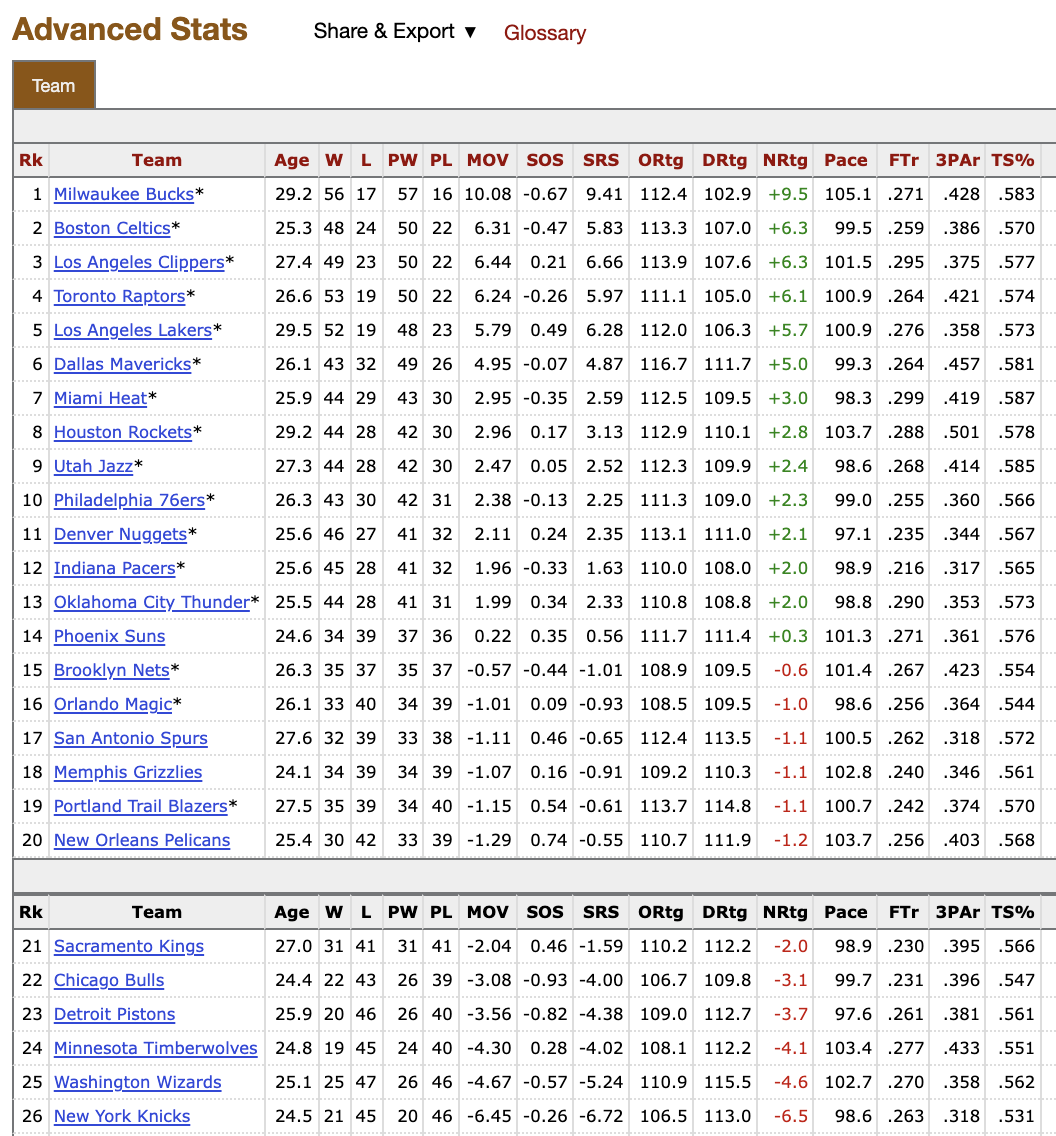
source: https://www.basketball-reference.com/leagues/NBA_2020.html

You can see that the team names are stored in the hyperlink. I don't need the team's full name, I only need its abbreviation. So I want to do a mapping from the team's full name to the team's abbreviation. I can get the abbreviation by scrapping the URL of each team's links.

For example, the URL for Los Angeles Lakers hyperlink is https://www.basketball-reference.com/teams/LAL/2020.html. So I want to scrap that URL and using regex to get "LAL".

The id for the table that contains team records is 'advanced-team'. So I'm using BeautifulSoup to scrap the table with id 'advanced-team'. Because I want the URL of each team, I want to get the a tags to get href.

In [3]:
season = 2010
url = f'https://www.basketball-reference.com/leagues/NBA_{season}.html'
table_html = BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id = re.compile('advanced-team'))[0].findAll('a')
table_html

[<a href="/teams/ORL/2010.html">Orlando Magic</a>,
 <a href="/teams/CLE/2010.html">Cleveland Cavaliers</a>,
 <a href="/teams/UTA/2010.html">Utah Jazz</a>,
 <a href="/teams/SAS/2010.html">San Antonio Spurs</a>,
 <a href="/teams/ATL/2010.html">Atlanta Hawks</a>,
 <a href="/teams/PHO/2010.html">Phoenix Suns</a>,
 <a href="/teams/LAL/2010.html">Los Angeles Lakers</a>,
 <a href="/teams/DEN/2010.html">Denver Nuggets</a>,
 <a href="/teams/BOS/2010.html">Boston Celtics</a>,
 <a href="/teams/POR/2010.html">Portland Trail Blazers</a>,
 <a href="/teams/OKC/2010.html">Oklahoma City Thunder</a>,
 <a href="/teams/DAL/2010.html">Dallas Mavericks</a>,
 <a href="/teams/MIA/2010.html">Miami Heat</a>,
 <a href="/teams/MIL/2010.html">Milwaukee Bucks</a>,
 <a href="/teams/CHA/2010.html">Charlotte Bobcats</a>,
 <a href="/teams/HOU/2010.html">Houston Rockets</a>,
 <a href="/teams/MEM/2010.html">Memphis Grizzlies</a>,
 <a href="/teams/CHI/2010.html">Chicago Bulls</a>,
 <a href="/teams/TOR/2010.html">Toronto R

As mentioned above, I will use regex to get the team abbreviation. I also want the abbreviation stored in a list next with its full name

In [4]:
team_name = []
team_abrv = []
for html in table_html:
  abrv = html.get('href')
  pattern = re.compile(r'([A-Z]{3})')
  team_abrv.append(pattern.search(abrv).group())
  team_name.append(html.text)
team_abrv = list(zip(team_name,team_abrv))
team_abrv

[('Orlando Magic', 'ORL'),
 ('Cleveland Cavaliers', 'CLE'),
 ('Utah Jazz', 'UTA'),
 ('San Antonio Spurs', 'SAS'),
 ('Atlanta Hawks', 'ATL'),
 ('Phoenix Suns', 'PHO'),
 ('Los Angeles Lakers', 'LAL'),
 ('Denver Nuggets', 'DEN'),
 ('Boston Celtics', 'BOS'),
 ('Portland Trail Blazers', 'POR'),
 ('Oklahoma City Thunder', 'OKC'),
 ('Dallas Mavericks', 'DAL'),
 ('Miami Heat', 'MIA'),
 ('Milwaukee Bucks', 'MIL'),
 ('Charlotte Bobcats', 'CHA'),
 ('Houston Rockets', 'HOU'),
 ('Memphis Grizzlies', 'MEM'),
 ('Chicago Bulls', 'CHI'),
 ('Toronto Raptors', 'TOR'),
 ('New Orleans Hornets', 'NOH'),
 ('Indiana Pacers', 'IND'),
 ('Golden State Warriors', 'GSW'),
 ('New York Knicks', 'NYK'),
 ('Philadelphia 76ers', 'PHI'),
 ('Sacramento Kings', 'SAC'),
 ('Washington Wizards', 'WAS'),
 ('Detroit Pistons', 'DET'),
 ('Los Angeles Clippers', 'LAC'),
 ('Minnesota Timberwolves', 'MIN'),
 ('New Jersey Nets', 'NJN')]

Now the mapping is done. The next thing to do is to get the team records by scrapping the 'advanced-stats' table, and then convert the team's full name to its abbreviation using the mapping that I created.

In [9]:
table = BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id = re.compile('advanced-team'))
team_records = pd.read_html(str(table))[0]
team_records = team_records.apply(pd.to_numeric, errors = 'coerce').fillna(team_records) # convert non string values to numeric
team_records.columns = team_records.columns.droplevel(0) # drop header
team_records = team_records.drop('Rk', 1) # drop Rk columns
team_records = team_records.loc[:,['Team','W','L']] # only select team names and its winning and losing records
team_records.Team = team_records.Team.str.replace('*','') # remove team names asterisk

team_names = [i[0] for i in team_abrv] # get list of team names
team_abbrevation = [i[1] for i in team_abrv] # get list of team abbrevation
for team,i in zip(team_records.Team,team_records.index.values): # the mapping process
  if team in team_names:
    idx = (team_names.index(team))
    team_records.Team[i] = team_abbrevation[idx]
  else:
    pass
team_records

,Team,W,L
0,ORL,59,23
1,CLE,61,21
2,UTA,53,29
3,SAS,50,32
4,ATL,53,29
5,PHO,54,28
6,LAL,57,25
7,DEN,53,29
8,BOS,50,32
9,POR,50,32


The final function is:

In [47]:
def team_records(season):
  url = f'https://www.basketball-reference.com/leagues/NBA_{season}.html'
  table_html = BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id = re.compile('advanced-team'))[0].findAll('a')
  table_html
  team_name = []
  team_abrv = []
  for html in table_html:
    abrv = html.get('href')
    pattern = re.compile(r'([A-Z]{3})')
    team_abrv.append(pattern.search(abrv).group())
    team_name.append(html.text)
  team_abrv = list(zip(team_name,team_abrv))

  table = BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id = re.compile('advanced-team'))
  team_records = pd.read_html(str(table))[0]
  team_records = team_records.apply(pd.to_numeric, errors = 'coerce').fillna(team_records)
  team_records.columns = team_records.columns.droplevel(0)
  team_records = team_records.drop('Rk', 1) # drop Rk columns
  team_records = team_records.loc[:,['Team','W','L']] # only select team names and its winning and losing records
  team_records.Team = team_records.Team.str.replace('*','') # remove team names asterisk

  team_names = [i[0] for i in team_abrv] # get list of team names
  team_abbrevation = [i[1] for i in team_abrv] # get list of team abbrevation
  for team,i in zip(team_records.Team,team_records.index.values): # the mapping process
    if team in team_names:
      idx = (team_names.index(team))
      team_records.Team[i] = team_abbrevation[idx]
    else:
      pass
  return team_records
team_records(2020)

,Team,W,L
0,MIL,56,17
1,BOS,48,24
2,LAC,49,23
3,TOR,53,19
4,LAL,52,19
5,DAL,43,32
6,MIA,44,29
7,HOU,44,28
8,UTA,44,28
9,PHI,43,30


# 4. Get single season stats

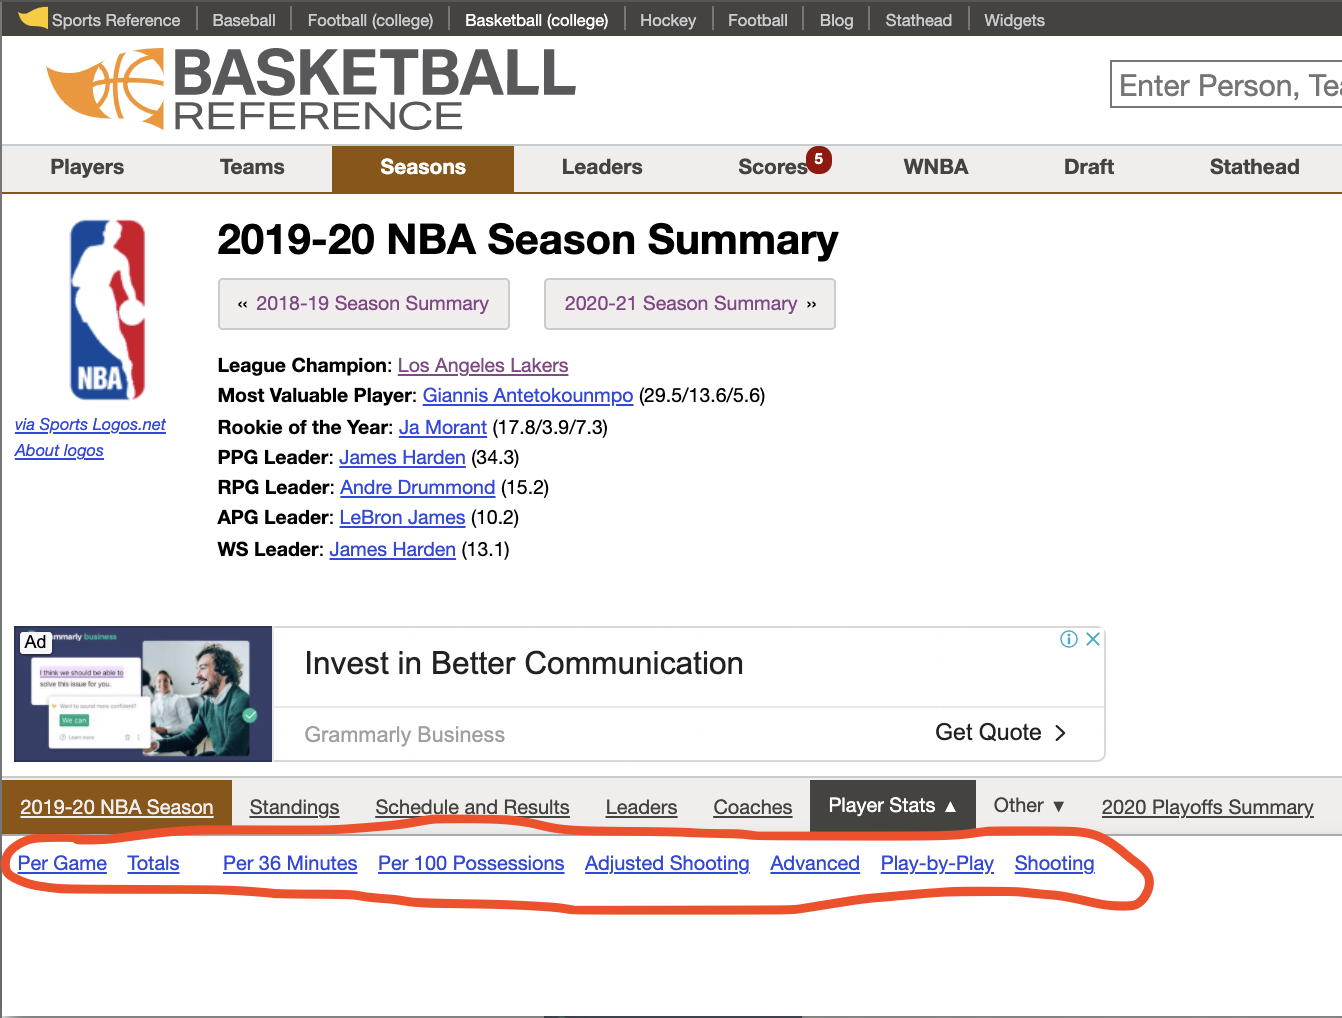

source: https://www.basketball-reference.com/leagues/NBA_2020.html

To get the players stats, we need to go to one of the links I circeled above. Now let's open [Per Game](https://www.basketball-reference.com/leagues/NBA_2020_per_game.html) link.

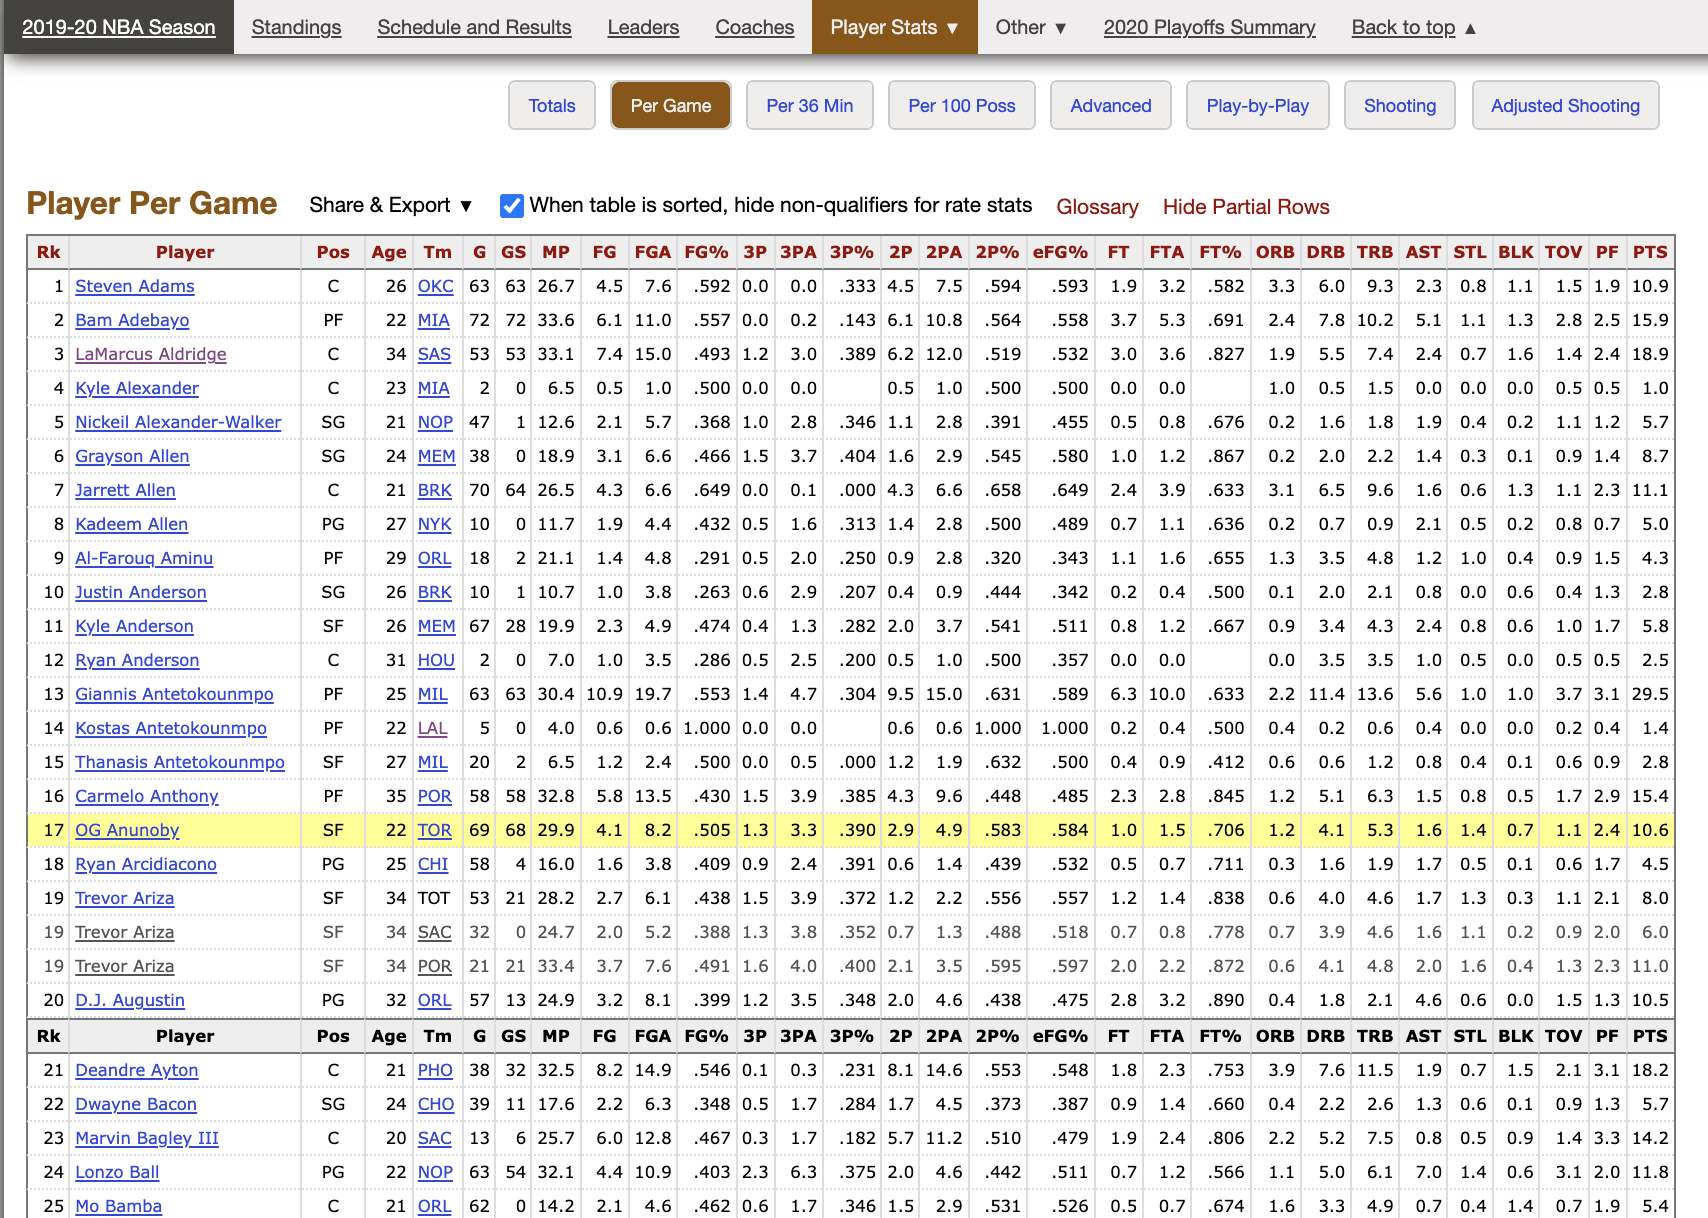
source: https://www.basketball-reference.com/leagues/NBA_2020_per_game.html

Note that each stats argument are followed by the initial link. For example, if we want the *advanced* stats in the 2020 season, the url is https://www.basketball-reference.com/leagues/NBA_2020_advanced.html. So the url will be formatted with *season* and *stats* argument.

In [17]:
season = 2020
stats = 'per_game'
url = f'https://www.basketball-reference.com/leagues/NBA_{season}_{stats}.html'
print(url)

https://www.basketball-reference.com/leagues/NBA_2020_per_game.html


In [22]:
table_html = BeautifulSoup(urlopen(url), 'html.parser').findAll('table')
df = pd.read_html(str(table_html))[0]
df

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Steven Adams,C,26,OKC,63,63,26.7,4.5,7.6,.592,0.0,0.0,.333,4.5,7.5,.594,.593,1.9,3.2,.582,3.3,6.0,9.3,2.3,0.8,1.1,1.5,1.9,10.9
1,2,Bam Adebayo,PF,22,MIA,72,72,33.6,6.1,11.0,.557,0.0,0.2,.143,6.1,10.8,.564,.558,3.7,5.3,.691,2.4,7.8,10.2,5.1,1.1,1.3,2.8,2.5,15.9
2,3,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,.493,1.2,3.0,.389,6.2,12.0,.519,.532,3.0,3.6,.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
3,4,Kyle Alexander,C,23,MIA,2,0,6.5,0.5,1.0,.500,0.0,0.0,NaN,0.5,1.0,.500,.500,0.0,0.0,NaN,1.0,0.5,1.5,0.0,0.0,0.0,0.5,0.5,1.0
4,5,Nickeil Alexander-Walker,SG,21,NOP,47,1,12.6,2.1,5.7,.368,1.0,2.8,.346,1.1,2.8,.391,.455,0.5,0.8,.676,0.2,1.6,1.8,1.9,0.4,0.2,1.1,1.2,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,525,Trae Young,PG,21,ATL,60,60,35.3,9.1,20.8,.437,3.4,9.5,.361,5.7,11.4,.501,.519,8.0,9.3,.860,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6
673,526,Cody Zeller,C,27,CHO,58,39,23.1,4.3,8.3,.524,0.3,1.3,.240,4.0,7.0,.577,.543,2.1,3.1,.682,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1
674,527,Tyler Zeller,C,30,SAS,2,0,2.0,0.5,2.0,.250,0.0,0.0,NaN,0.5,2.0,.250,.250,0.0,0.0,NaN,1.5,0.5,2.0,0.0,0.0,0.0,0.0,0.0,1.0
675,528,Ante Žižić,C,23,CLE,22,0,10.0,1.9,3.3,.569,0.0,0.0,NaN,1.9,3.3,.569,.569,0.6,0.9,.737,0.8,2.2,3.0,0.3,0.3,0.2,0.5,1.2,4.4


Note that the data is still not clean. For example, there are still a column header in the middle of the table
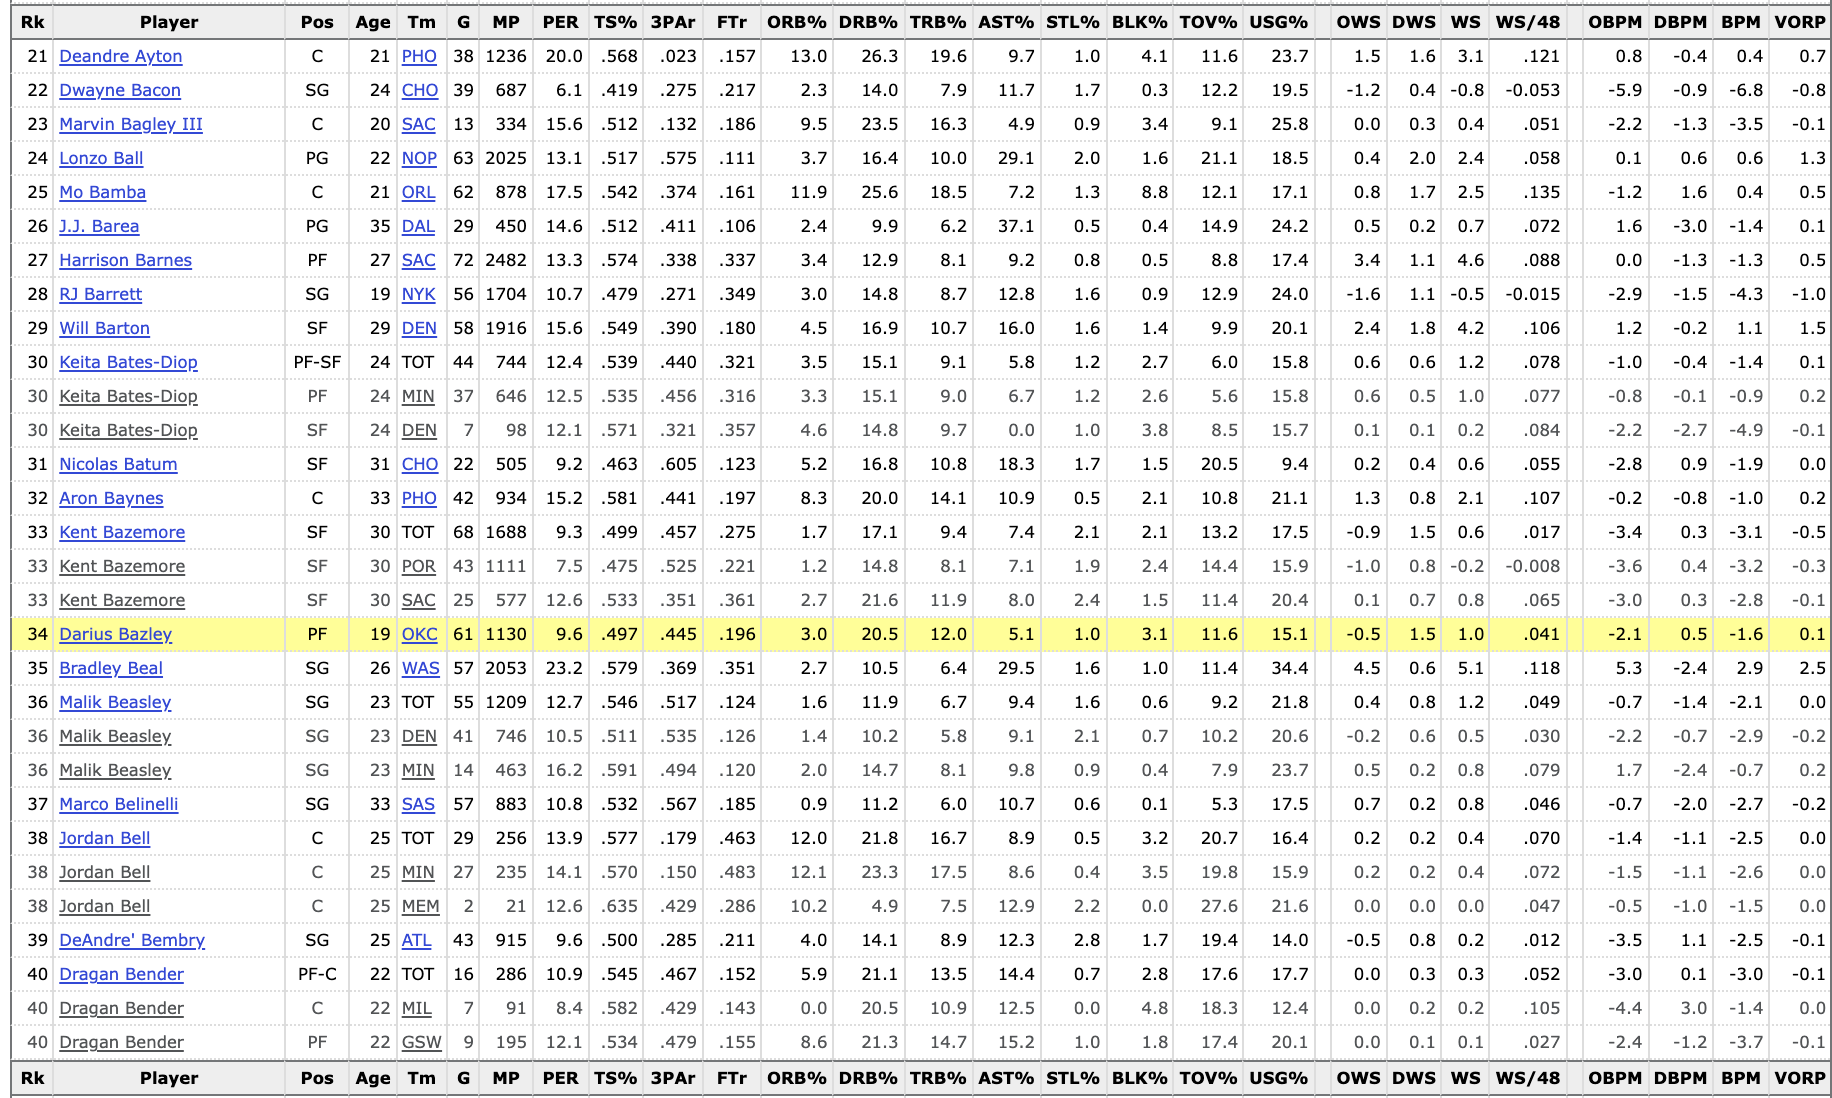



Here are the row mentioned:

In [20]:
df[df.Player == 'Player'].iloc[1:10]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
53,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
76,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
101,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
130,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
163,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
192,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
219,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
242,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
271,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


In [23]:
df = df.drop(df[df.Player == 'Player'].index) # drop row contains table header
df = df.drop('Rk', 1) # drop Rk columns
df.Player = df.Player.str.replace('*','') # remove asterisk on player's name
df = df.apply(pd.to_numeric, errors='coerce').fillna(df) # convert non string values to numeric
df

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Steven Adams,C,26,OKC,63,63,26.7,4.5,7.6,0.592,0,0,0.333,4.5,7.5,0.594,0.593,1.9,3.2,0.582,3.3,6,9.3,2.3,0.8,1.1,1.5,1.9,10.9
1,Bam Adebayo,PF,22,MIA,72,72,33.6,6.1,11,0.557,0,0.2,0.143,6.1,10.8,0.564,0.558,3.7,5.3,0.691,2.4,7.8,10.2,5.1,1.1,1.3,2.8,2.5,15.9
2,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15,0.493,1.2,3,0.389,6.2,12,0.519,0.532,3,3.6,0.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
3,Kyle Alexander,C,23,MIA,2,0,6.5,0.5,1,0.5,0,0,NaN,0.5,1,0.5,0.5,0,0,NaN,1,0.5,1.5,0,0,0,0.5,0.5,1
4,Nickeil Alexander-Walker,SG,21,NOP,47,1,12.6,2.1,5.7,0.368,1,2.8,0.346,1.1,2.8,0.391,0.455,0.5,0.8,0.676,0.2,1.6,1.8,1.9,0.4,0.2,1.1,1.2,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,Trae Young,PG,21,ATL,60,60,35.3,9.1,20.8,0.437,3.4,9.5,0.361,5.7,11.4,0.501,0.519,8,9.3,0.86,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6
673,Cody Zeller,C,27,CHO,58,39,23.1,4.3,8.3,0.524,0.3,1.3,0.24,4,7,0.577,0.543,2.1,3.1,0.682,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1
674,Tyler Zeller,C,30,SAS,2,0,2,0.5,2,0.25,0,0,NaN,0.5,2,0.25,0.25,0,0,NaN,1.5,0.5,2,0,0,0,0,0,1
675,Ante Žižić,C,23,CLE,22,0,10,1.9,3.3,0.569,0,0,NaN,1.9,3.3,0.569,0.569,0.6,0.9,0.737,0.8,2.2,3,0.3,0.3,0.2,0.5,1.2,4.4


The final function is:

In [33]:
def single(season,stats):
  url = f'https://www.basketball-reference.com/leagues/NBA_{season}_{stats}.html'
  table_html = BeautifulSoup(urlopen(url), 'html.parser').findAll('table')
  df = pd.read_html(str(table_html))[0]
  df = df.drop(df[df.Player == 'Player'].index) # drop row contains table header
  df = df.drop('Rk', 1) # drop Rk columns
  df.Player = df.Player.str.replace('*','') # remove asterisk on player's name
  df.insert(0,'Season',season) # insert season column
  df = df.apply(pd.to_numeric, errors='coerce').fillna(df) # convert non string values to numeric
  return df
single(1998,'per_game')

,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1998,Mahmoud Abdul-Rauf,PG,28,SAC,31,0,17.1,3.3,8.8,0.377,0.2,1,0.161,3.2,7.8,0.405,0.386,0.5,0.5,1,0.2,1,1.2,1.9,0.5,0,0.6,1,7.3
1,1998,Tariq Abdul-Wahad,SG,23,SAC,59,16,16.3,2.4,6.1,0.403,0.1,0.3,0.211,2.4,5.7,0.414,0.409,1.4,2.1,0.672,0.7,1.2,2,0.9,0.6,0.2,1.1,1.4,6.4
2,1998,Shareef Abdur-Rahim,SF,21,VAN,82,82,36,8,16.4,0.485,0.3,0.6,0.412,7.7,15.8,0.488,0.493,6.1,7.8,0.784,2.8,4.3,7.1,2.6,1.1,0.9,3.1,2.5,22.3
3,1998,Cory Alexander,PG,24,TOT,60,22,21.6,2.9,6.7,0.428,1.1,2.9,0.375,1.8,3.7,0.469,0.51,1.3,1.7,0.784,0.3,2.2,2.4,3.5,1.2,0.2,1.9,1.6,8.1
4,1998,Cory Alexander,PG,24,SAS,37,3,13.5,1.6,3.9,0.414,0.5,1.7,0.313,1.1,2.2,0.494,0.483,0.7,1,0.676,0.2,1.1,1.3,1.9,0.7,0.1,1.3,1.4,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,1998,Lorenzen Wright,C,22,LAC,69,38,30,3.5,7.9,0.445,0,0,0,3.5,7.8,0.446,0.445,2,3.1,0.659,2.6,6.2,8.8,0.8,0.8,1.3,1.2,3.4,9
564,1998,Sharone Wright,C,25,TOR,7,0,6.3,1,2,0.5,0,0,NaN,1,2,0.5,0.5,0.3,0.6,0.5,0.1,1.1,1.3,0.6,0,0,0.3,1,2.3
565,1998,George Zídek,C,24,TOT,12,0,5.3,0.6,2.4,0.241,0.1,0.2,0.5,0.5,2.3,0.222,0.259,1.2,1.3,0.875,0.3,1.1,1.4,0.2,0,0.2,0.3,0.8,2.4
566,1998,George Zídek,C,24,DEN,6,0,7,0.7,2.5,0.267,0,0,NaN,0.7,2.5,0.267,0.267,1.7,2,0.833,0.7,1.5,2.2,0.2,0,0.3,0.5,0.8,3


# 5. Get multiple season stats

This function basically iterates the previous function. We only need to set the *start_year* and *end_year* and then iterates using while loop.

In [36]:
def multiple(start_year,end_year,stats):
  df = single(start_year,stats)
  while start_year < end_year:
    start_year = start_year + 1
    df = df.append(single(start_year,stats))
  return df
multiple(2018,2020,'per_game')

,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2018,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.38,0.4,0.9,0.443,0.54,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7
1,2018,Quincy Acy,PF,27,BRK,70,8,19.4,1.9,5.2,0.356,1.5,4.2,0.349,0.4,1,0.384,0.496,0.7,0.9,0.817,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9
2,2018,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,0,0,0,5.9,9.3,0.631,0.629,2.1,3.8,0.559,5.1,4,9,1.2,1.2,1,1.7,2.8,13.9
3,2018,Bam Adebayo,C,20,MIA,69,19,19.8,2.5,4.9,0.512,0,0.1,0,2.5,4.8,0.523,0.512,1.9,2.6,0.721,1.7,3.8,5.5,1.5,0.5,0.6,1,2,6.9
4,2018,Arron Afflalo,SG,32,ORL,53,3,12.9,1.2,3.1,0.401,0.5,1.3,0.386,0.7,1.7,0.413,0.485,0.4,0.5,0.846,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,2020,Trae Young,PG,21,ATL,60,60,35.3,9.1,20.8,0.437,3.4,9.5,0.361,5.7,11.4,0.501,0.519,8,9.3,0.86,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6
673,2020,Cody Zeller,C,27,CHO,58,39,23.1,4.3,8.3,0.524,0.3,1.3,0.24,4,7,0.577,0.543,2.1,3.1,0.682,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1
674,2020,Tyler Zeller,C,30,SAS,2,0,2,0.5,2,0.25,0,0,NaN,0.5,2,0.25,0.25,0,0,NaN,1.5,0.5,2,0,0,0,0,0,1
675,2020,Ante Žižić,C,23,CLE,22,0,10,1.9,3.3,0.569,0,0,NaN,1.9,3.3,0.569,0.569,0.6,0.9,0.737,0.8,2.2,3,0.3,0.3,0.2,0.5,1.2,4.4


# Feature Engineering

Suppose we want to predict the player who win MVP, or selected to the all-star game. We need to put the MVP or all-star information to the player stats. This section show you the process of adding those features.

### Adding all-star column

In [40]:
df = single(2010,'per_game')
df['All_Star'] = 0
if season == '1999':
  pass # No all star game in 1999 season
else:
  all_star = get_allstar(2010)
  df.loc[df['Player'].isin(all_star), 'All_Star'] = 1  # change all star column to 1 if the player is in the all star list
df[df.All_Star==1]

,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All_Star
15,2010,Carmelo Anthony,SF,25,DEN,69,69,38.2,10,21.8,0.458,0.9,2.7,0.316,9.1,19.1,0.478,0.478,7.4,8.9,0.83,2.2,4.4,6.6,3.2,1.3,0.4,3,3.3,28.2,1
53,2010,Chauncey Billups,PG,33,DEN,73,73,34.1,5.5,13.2,0.418,2.2,5.6,0.386,3.4,7.6,0.441,0.499,6.4,7,0.91,0.3,2.8,3.1,5.6,1.1,0.1,2.4,2.1,19.5,1
64,2010,Chris Bosh,C,25,TOR,70,70,36.1,8.6,16.5,0.518,0.1,0.3,0.364,8.5,16.2,0.521,0.522,6.7,8.4,0.797,2.9,7.9,10.8,2.4,0.6,1,2.4,2.4,24,1
87,2010,Kobe Bryant,SG,31,LAL,73,73,38.8,9.8,21.5,0.456,1.4,4.1,0.329,8.5,17.4,0.487,0.488,6,7.4,0.811,1.1,4.3,5.4,5,1.5,0.3,3.2,2.6,27,1
153,2010,Tim Duncan,C,33,SAS,78,77,31.3,7.2,13.9,0.518,0,0.1,0.182,7.2,13.7,0.522,0.519,3.5,4.8,0.725,2.8,7.3,10.1,3.2,0.6,1.5,1.8,1.9,17.9,1
155,2010,Kevin Durant,SF,21,OKC,82,82,39.5,9.7,20.3,0.476,1.6,4.3,0.365,8.1,16.1,0.506,0.514,9.2,10.2,0.9,1.3,6.3,7.6,2.8,1.4,1,3.3,2.1,30.1,1
182,2010,Kevin Garnett,PF,33,BOS,69,69,29.9,5.8,11.2,0.521,0,0.1,0.2,5.8,11.1,0.523,0.521,2.7,3.2,0.837,1.1,6.2,7.3,2.7,1,0.8,1.5,2.5,14.3,1
184,2010,Pau Gasol,C,29,LAL,65,65,37,7,13,0.536,0,0.1,0,7,12.9,0.539,0.536,4.4,5.6,0.79,3.7,7.6,11.3,3.4,0.6,1.7,2.2,2.3,18.3,1
250,2010,Al Horford,C,23,ATL,81,81,35.1,5.8,10.5,0.551,0,0,1,5.8,10.4,0.551,0.552,2.6,3.3,0.789,2.9,7,9.9,2.3,0.7,1.1,1.5,2.8,14.2,1
255,2010,Dwight Howard,C,24,ORL,82,82,34.7,6.2,10.2,0.612,0,0.1,0,6.2,10.1,0.617,0.612,5.9,10,0.592,3.5,9.7,13.2,1.8,0.9,2.8,3.3,3.5,18.3,1


### Adding MVP column

In [45]:
df = single(2008,'per_game')
df['MVP'] = 0
mvp = get_mvp(2008)
df.loc[df['Player'] == mvp, 'MVP'] = 1 
df[df.MVP == 1]

,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MVP
85,2008,Kobe Bryant,SG,29,LAL,82,82,38.9,9.5,20.6,0.459,1.8,5.1,0.361,7.6,15.5,0.49,0.503,7.6,9,0.84,1.1,5.2,6.3,5.4,1.8,0.5,3.1,2.8,28.3,1


### Adding team records to the players stats

In [48]:
df = single(2001, 'per_game')
team_records_list = team_records(2001).values.tolist()
df['team_win'] = 0
df['team_lose'] = 0
teams = [i[0] for i in team_records_list] # get list of team names
win = [i[1] for i in team_records_list] # get list of team winning records
lose = [i[2] for i in team_records_list] # get list of team losing records

for team,i in zip(df.Tm,(df.Tm.index.values)): # there's a missing index so the iteration is going through the index values
  if team in teams: 
    idx = (teams.index(team)) # get index in the team_records_list
    df.team_win[i]= win[idx] # add win records to df
    df.team_lose[i]= lose[idx] # add win records to df
  else:
    df.team_win[i] = 0
    df.team_lose[i] = 0
df

,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,team_win,team_lose
0,2001,Mahmoud Abdul-Rauf,PG,31,VAN,41,0,11.9,2.9,6,0.488,0.1,0.3,0.286,2.8,5.7,0.5,0.496,0.5,0.7,0.759,0.1,0.5,0.6,1.9,0.2,0,0.6,1.2,6.5,23,59
1,2001,Tariq Abdul-Wahad,SG,26,DEN,29,12,14.5,1.5,3.8,0.387,0.1,0.3,0.4,1.3,3.5,0.386,0.405,0.7,1.2,0.583,0.5,1.6,2,0.8,0.5,0.4,1.2,1.9,3.8,40,42
2,2001,Shareef Abdur-Rahim,SF,24,VAN,81,81,40,7.5,15.8,0.472,0.1,0.8,0.188,7.3,15,0.487,0.477,5.5,6.6,0.834,2.2,6.9,9.1,3.1,1.1,1,2.9,2.9,20.5,23,59
3,2001,Cory Alexander,PG,27,ORL,26,0,8.7,0.7,2.2,0.321,0.2,0.6,0.25,0.5,1.5,0.35,0.357,0.5,0.7,0.667,0,1,1,1.4,0.6,0,1,1.1,2,43,39
4,2001,Courtney Alexander,PG,23,TOT,65,24,21.3,3.7,8.8,0.417,0.3,0.7,0.37,3.4,8.1,0.421,0.432,1.9,2.3,0.82,0.6,1.6,2.2,1,0.7,0.1,1.2,2.1,9.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,2001,David Wingate,SG,37,SEA,1,0,9,3,3,1,0,0,NaN,3,3,1,1,0,0,NaN,0,0,0,2,0,0,0,1,6,44,38
554,2001,Rubén Wolkowyski,PF,27,SEA,34,1,9,0.7,2.3,0.316,0,0.1,0,0.7,2.3,0.325,0.316,0.7,1,0.735,0.4,1,1.4,0.1,0.2,0.5,0.4,1.1,2.2,44,38
555,2001,Metta World Peace,SF,21,CHI,76,74,31.1,4.3,10.7,0.401,0.6,1.9,0.291,3.7,8.8,0.426,0.428,2.8,3.7,0.75,0.8,3.1,3.9,3,2,0.6,2.1,3.3,11.9,15,67
556,2001,Lorenzen Wright,C,25,ATL,71,46,28,5.1,11.4,0.448,0,0,0,5.1,11.4,0.449,0.448,2.2,3,0.718,2.5,5,7.5,1.2,0.6,0.9,1.8,3.3,12.4,25,57


# Create class to gather all the function

In [81]:
class hoopscrapper:

  class awards:

    def mvp(season):
      season = str(season)
      url = 'https://www.basketball-reference.com/awards/mvp.html'
      table_html = str(BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id = 'mvp_NBA')[0])

      df = pd.read_html(table_html)[0]
      df.columns = df.columns.droplevel(0)
      df = df[['Season','Player']]
      df['Season'][0]

      for i in range(len(df)):
        df['Season'][i] = df['Season'][i][0:2] + df['Season'][i][5:7]

      mvp_lists = df.values.tolist()

      for data in mvp_lists:
        if season in data[0]:
          return data[1]

    def allstar(season):
      if season == 1999:
        print('No All Star game in 1999 season') # No all star game in 1999 season

      else:  
        url = f'https://www.basketball-reference.com/allstar/NBA_{season}.html'
        name_html = BeautifulSoup(urlopen(url),'html.parser').findAll('a', string = re.compile('[a-z]'), href = re.compile('^/players/.+'), title= False) 
        names = [names.text for names in name_html]
        names = list(set(names))

        return names


  class get_data:

    def team_records(season):
      url = f'https://www.basketball-reference.com/leagues/NBA_{season}.html'
      table_html = BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id = re.compile('advanced-team'))[0].findAll('a')
      table_html
      team_name = []
      team_abrv = []

      for html in table_html:
        abrv = html.get('href')
        pattern = re.compile(r'([A-Z]{3})')
        team_abrv.append(pattern.search(abrv).group())
        team_name.append(html.text)
      team_abrv = list(zip(team_name,team_abrv))

      table = BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id = re.compile('advanced-team'))
      team_records = pd.read_html(str(table))[0]
      team_records = team_records.apply(pd.to_numeric, errors = 'coerce').fillna(team_records)
      team_records.columns = team_records.columns.droplevel(0)
      team_records = team_records.drop('Rk', 1) # drop Rk columns
      team_records = team_records.loc[:,['Team','W','L']] # only select team names and its winning and losing records
      team_records.Team = team_records.Team.str.replace('*','') # remove team names asterisk

      team_names = [i[0] for i in team_abrv] # get list of team names
      team_abbrevation = [i[1] for i in team_abrv] # get list of team abbrevation
      for team,i in zip(team_records.Team,team_records.index.values): # the mapping process
        if team in team_names:
          idx = (team_names.index(team))
          team_records.Team[i] = team_abbrevation[idx]
        else:
          pass

      return team_records

    def single(season,stats):
      print('Loading',season,'data...')
      url = f'https://www.basketball-reference.com/leagues/NBA_{season}_{stats}.html'
      table_html = BeautifulSoup(urlopen(url), 'html.parser').findAll('table')

      df = pd.read_html(str(table_html))[0]
      df = df.drop(df[df.Player == 'Player'].index) # drop row contains table header
      df = df.drop('Rk', 1) # drop Rk columns
      df.Player = df.Player.str.replace('*','') # remove asterisk on player's name
      df.insert(0,'Season',season) # insert season column
      df = df.apply(pd.to_numeric, errors='coerce').fillna(df) # convert non string values to numeric

      # OPTIONAL
      # If you want to put all-star and mvp column to the player stats data frame, open this hash. Note that it will slows the process.

      # Insert all-star column
      df['All_Star'] = 0
      if season == 1999:
        pass # No all star game in 1999 season
      else:
        all_star = hoopscrapper.awards.allstar(season)
        df.loc[df['Player'].isin(all_star), 'All_Star'] = 1  # change all star column to 1 if the player is in the all star list
      df[df.All_Star==1]

      # Insert MVP column
      df['MVP'] = 0
      mvp = hoopscrapper.awards.mvp(season)
      df.loc[df['Player'] == mvp, 'MVP'] = 1 
      df[df.MVP == 1]

      # Insert team records
      team_records_list = hoopscrapper.get_data.team_records(season).values.tolist()
      df['team_win'] = 0
      df['team_lose'] = 0
      teams = [i[0] for i in team_records_list] # get list of team names
      win = [i[1] for i in team_records_list] # get list of team winning records
      lose = [i[2] for i in team_records_list] # get list of team losing records

      for team,i in zip(df.Tm,(df.Tm.index.values)): # there's a missing index so the iteration is going through the index values
        if team in teams: 
          idx = (teams.index(team)) # get index in the team_records_list
          df.team_win[i]= win[idx] # add win records to df
          df.team_lose[i]= lose[idx] # add win records to df
        else:
          df.team_win[i] = 0
          df.team_lose[i] = 0

      return df


    def multiple(start_year,end_year,stats):
      df = hoopscrapper.get_data.single(start_year,stats)
      while start_year < end_year:
        start_year = start_year + 1
        df = df.append(hoopscrapper.get_data.single(start_year,stats))

      return df

In [71]:
hoopscrapper.get_data.single(2020,'per_game')

Loading 2020 data...


,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All_Star,MVP,team_win,team_lose
0,2020,Steven Adams,C,26,OKC,63,63,26.7,4.5,7.6,0.592,0,0,0.333,4.5,7.5,0.594,0.593,1.9,3.2,0.582,3.3,6,9.3,2.3,0.8,1.1,1.5,1.9,10.9,0,0,44,28
1,2020,Bam Adebayo,PF,22,MIA,72,72,33.6,6.1,11,0.557,0,0.2,0.143,6.1,10.8,0.564,0.558,3.7,5.3,0.691,2.4,7.8,10.2,5.1,1.1,1.3,2.8,2.5,15.9,1,0,44,29
2,2020,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15,0.493,1.2,3,0.389,6.2,12,0.519,0.532,3,3.6,0.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9,0,0,32,39
3,2020,Kyle Alexander,C,23,MIA,2,0,6.5,0.5,1,0.5,0,0,NaN,0.5,1,0.5,0.5,0,0,NaN,1,0.5,1.5,0,0,0,0.5,0.5,1,0,0,44,29
4,2020,Nickeil Alexander-Walker,SG,21,NOP,47,1,12.6,2.1,5.7,0.368,1,2.8,0.346,1.1,2.8,0.391,0.455,0.5,0.8,0.676,0.2,1.6,1.8,1.9,0.4,0.2,1.1,1.2,5.7,0,0,30,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,2020,Trae Young,PG,21,ATL,60,60,35.3,9.1,20.8,0.437,3.4,9.5,0.361,5.7,11.4,0.501,0.519,8,9.3,0.86,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6,1,0,20,47
673,2020,Cody Zeller,C,27,CHO,58,39,23.1,4.3,8.3,0.524,0.3,1.3,0.24,4,7,0.577,0.543,2.1,3.1,0.682,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1,0,0,23,42
674,2020,Tyler Zeller,C,30,SAS,2,0,2,0.5,2,0.25,0,0,NaN,0.5,2,0.25,0.25,0,0,NaN,1.5,0.5,2,0,0,0,0,0,1,0,0,32,39
675,2020,Ante Žižić,C,23,CLE,22,0,10,1.9,3.3,0.569,0,0,NaN,1.9,3.3,0.569,0.569,0.6,0.9,0.737,0.8,2.2,3,0.3,0.3,0.2,0.5,1.2,4.4,0,0,19,46


In [83]:
# hoopscrapper.get_data.single(2020,'per_game')
start_time = datetime.now()
df = hoopscrapper.get_data.multiple(1980,2021,'per_game')
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) 
df

Loading 1980 data...
Loading 1981 data...
Loading 1982 data...
Loading 1983 data...
Loading 1984 data...
Loading 1985 data...
Loading 1986 data...
Loading 1987 data...
Loading 1988 data...
Loading 1989 data...
Loading 1990 data...
Loading 1991 data...
Loading 1992 data...
Loading 1993 data...
Loading 1994 data...
Loading 1995 data...
Loading 1996 data...
Loading 1997 data...
Loading 1998 data...
Loading 1999 data...
Loading 2000 data...
Loading 2001 data...
Loading 2002 data...
Loading 2003 data...
Loading 2004 data...
Loading 2005 data...
Loading 2006 data...
Loading 2007 data...
Loading 2008 data...
Loading 2009 data...
Loading 2010 data...
Loading 2011 data...
Loading 2012 data...
Loading 2013 data...
Loading 2014 data...
Loading 2015 data...
Loading 2016 data...
Loading 2017 data...
Loading 2018 data...
Loading 2019 data...
Loading 2020 data...
Loading 2021 data...
Duration: 0:03:07.922600


,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All_Star,MVP,team_win,team_lose
0,1980,Kareem Abdul-Jabbar,C,32,LAL,82,NaN,38.3,10.2,16.9,0.604,0,0,0,10.2,16.9,0.604,0.604,4.4,5.8,0.765,2.3,8.5,10.8,4.5,1,3.4,3.6,2.6,24.8,1,1,60,22
1,1980,Tom Abernethy,PF,25,GSW,67,NaN,18.2,2.3,4.7,0.481,0,0,0,2.3,4.7,0.483,0.481,0.8,1.2,0.683,0.9,1.9,2.9,1.3,0.5,0.2,0.6,1.8,5.4,0,0,24,58
2,1980,Alvan Adams,C,25,PHO,75,NaN,28.9,6.2,11.7,0.531,0,0,0,6.2,11.6,0.533,0.531,2.5,3.1,0.797,2.1,6,8.1,4.3,1.4,0.7,2.9,3.2,14.9,0,0,55,27
3,1980,Tiny Archibald,PG,31,BOS,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,4.7,9.7,0.488,0.485,4.5,5.4,0.83,0.7,1.7,2.5,8.4,1.3,0.1,3,2.7,14.1,1,0,61,21
4,1980,Dennis Awtrey,C,31,CHI,26,NaN,21.5,1,2.3,0.45,0,0,NaN,1,2.3,0.45,0.45,1.2,1.9,0.64,1.1,3.3,4.4,1.5,0.5,0.6,1,2.5,3.3,0,0,30,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2021,Delon Wright,PG,28,SAC,27,8,25.8,3.9,8.3,0.462,1.2,3.1,0.398,2.6,5.3,0.5,0.536,1.1,1.3,0.833,1,2.9,3.9,3.6,1.6,0.4,1.3,1.1,10,0,0,31,41
727,2021,Thaddeus Young,PF,32,CHI,68,23,24.3,5.4,9.7,0.559,0.2,0.7,0.267,5.3,9.1,0.58,0.568,1,1.7,0.628,2.5,3.8,6.2,4.3,1.1,0.6,2,2.2,12.1,0,0,31,41
728,2021,Trae Young,PG,22,ATL,63,63,33.7,7.7,17.7,0.438,2.2,6.3,0.343,5.6,11.3,0.491,0.499,7.7,8.7,0.886,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,0,0,41,31
729,2021,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,0.559,0.1,0.6,0.143,3.7,6.2,0.598,0.565,1.8,2.5,0.714,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,0,0,33,39
